# TemporalVAE demo notebook with Embryo Beta cells

## Load data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
tvae_path = 'https://github.com/StatBiomed/TemporalVAE-reproducibility/raw/refs/heads/main'

Y = pd.read_csv(tvae_path + '/Fig2_TemproalVAE_against_benchmark_methods/' +
                'data_fromPsupertime/embryoBeta_Y.csv', index_col = 0)
Y.head()

,time
bE17.5_1_01,-1
bE17.5_1_02,-1
bE17.5_1_03,-1
bE17.5_1_04,-1
bE17.5_1_05,-1


In [3]:
X = pd.read_csv(tvae_path + '/Fig2_TemproalVAE_against_benchmark_methods/' +
                'data_fromPsupertime/embryoBeta_X.csv', index_col = 0)
X.head()

,bE17.5_1_01,bE17.5_1_02,bE17.5_1_03,bE17.5_1_04,bE17.5_1_05,bE17.5_2_01,bE17.5_2_02,bE17.5_2_03,bE17.5_2_04,bE17.5_2_05,...,bP0_2_30,bP0_2_31,bP9_2_24,bP9_2_25,bP9_2_26,bP9_4_13,bP15_1_21,bP15_1_22,bP60_1_40,bP60_3_30
Symbol,,,,,,,,,,,,,,,,,,,,,
Cdc45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27.61,0.00,...,0.00,0.00,20.62,0.00,0.00,67.31,53.64,0.0,0.00,0.00
H19,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.85,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Scml2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,8.42,0.0,0.00,0.00
Narf,18.44,47.67,16.61,6.71,37.55,25.99,15.69,17.02,13.69,0.00,...,38.78,0.00,0.00,6.34,3.59,7.88,0.00,0.0,14.64,30.85
Klf6,0.26,6.11,3.07,0.96,21.38,6.07,20.44,9.39,5.08,7.83,...,22.68,46.41,8.06,9.61,7.48,7.11,14.27,13.6,0.00,14.11


In [4]:
var_df = pd.DataFrame({'GeneName': X.index.values.astype('str')})
var_df.index = var_df['GeneName']

adata = sc.AnnData(X = X.values.transpose(), obs = Y, var = var_df)
adata

AnnData object with n_obs × n_vars = 575 × 3737
    obs: 'time'
    var: 'GeneName'

In [5]:
adata.obs.groupby(['time'])['time'].count()

time
-1      61
 0      84
 3      88
 9      81
 15     59
 18     71
 60    131
Name: time, dtype: int64

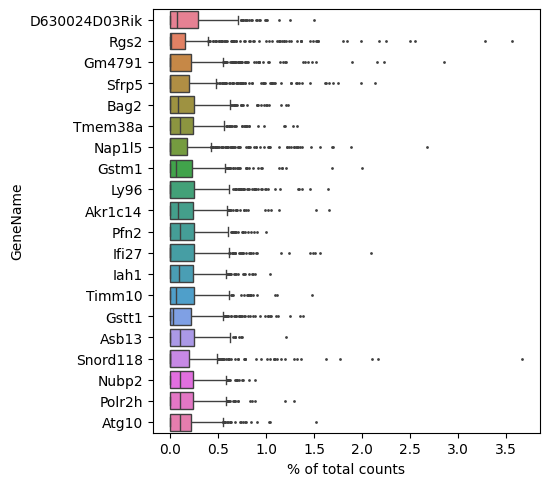

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [8]:
adata

AnnData object with n_obs × n_vars = 575 × 3737
    obs: 'time', 'n_genes'
    var: 'GeneName', 'n_cells'
    uns: 'log1p'

## Train TemporalVAE with NNWrapper

In [9]:
import torch
from torch import nn, Tensor
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(Tensor(adata.X), Tensor(adata.obs['time'].values.astype(np.float32)))
train_loader = DataLoader(train_data, batch_size=256, shuffle=False, drop_last=False)

In [10]:
import nnlite
print(nnlite.__version__)

0.0.3


In [11]:
from nnlite.models.stats import gaussian_loglik, gaussian_kl

def Loss_TVAE(result, target, fix_x_var=False, beta=1.0, 
              prior_mu=0.0, prior_sigma=1.0):
    """Naive loss for TVAE"""
    x_obs, y_obs = target
    x_hat, x_logstd, z, z_mean, z_logstd, y_hat = result
    
    if fix_x_var:
        x_logstd = x_logstd * 0
    
    # Calculate loss
    loglik = gaussian_loglik(x_obs, x_hat, x_logstd)
    kl = gaussian_kl(z_mean, z_logstd, prior_mu, prior_sigma)
    mse = torch.mean(torch.square(y_obs - y_hat))
    return -(loglik - beta * kl) + mse

In [12]:
import TemporalVAE as tvae
from nnlite import NNWrapper
from functools import partial

torch.manual_seed(0)
dev = 'cuda:2' if torch.cuda.is_available() else 'cpu'

model = tvae.models.TVAE_base(3737, 32, hidden_dims=[256, 128, 64], device=dev)
criterion = partial(Loss_TVAE, beta=0.1, fix_x_var=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.95)

my_wrapper = NNWrapper(model, criterion, optimizer, device=dev, reconstruct=True)
my_wrapper.fit(train_loader, epoch=1000, validation_loader=None, verbose=False)

100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.91it/s]


In [13]:
model

TVAE_base(
  (encoder): Sequential(
    (0): Identity()
    (L0): Linear(in_features=3737, out_features=256, bias=True)
    (A0): ReLU()
    (L1): Linear(in_features=256, out_features=128, bias=True)
    (A1): ReLU()
    (L2): Linear(in_features=128, out_features=64, bias=True)
    (A2): ReLU()
  )
  (fc_z_mean): Linear(in_features=64, out_features=32, bias=True)
  (fc_z_logstd): Linear(in_features=64, out_features=32, bias=True)
  (decoder): Sequential(
    (L0): Linear(in_features=32, out_features=64, bias=True)
    (A0): ReLU()
    (L1): Linear(in_features=64, out_features=128, bias=True)
    (A1): ReLU()
    (L2): Linear(in_features=128, out_features=256, bias=True)
    (A2): ReLU()
  )
  (fc_x_mean): Linear(in_features=256, out_features=3737, bias=True)
  (fc_x_logstd): Linear(in_features=1, out_features=3737, bias=False)
  (predictor): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

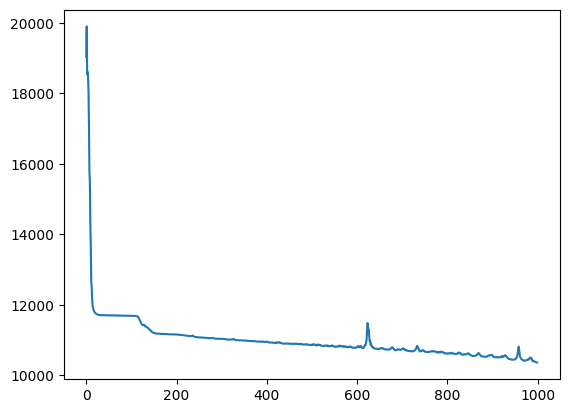

In [14]:
plt.plot(my_wrapper.train_losses)

In [15]:
data_X = torch.Tensor(adata.X).to(torch.device(dev))
data_Z = model.encoder(data_X)

In [16]:
data_Z

tensor([[ 0.0000, 10.4627,  0.0000,  ...,  6.5389,  0.0000,  0.0000],
        [ 0.0000, 13.7621,  0.0000,  ...,  8.3932,  0.0000,  0.0000],
        [ 0.0000, 10.2897,  0.0000,  ...,  6.3232,  0.0000,  0.0000],
        ...,
        [ 0.0000, 17.9042,  0.0000,  ...,  8.3939,  0.0000,  2.2306],
        [ 0.0000, 20.0610,  0.0000,  ...,  8.8392,  0.2557,  4.6667],
        [ 0.0000, 16.8094,  0.0000,  ...,  8.2870,  2.6366,  2.5247]],
       device='cuda:2', grad_fn=<ReluBackward0>)

In [17]:
adata1 = adata.copy()
adata1.obsm['X_pca'] = data_Z.cpu().data.numpy()
adata1.obs["time_group"] = adata1.obs['time'].values.astype('str')

sc.pp.neighbors(adata1, n_neighbors=10, n_pcs=32)
sc.tl.umap(adata1)

/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


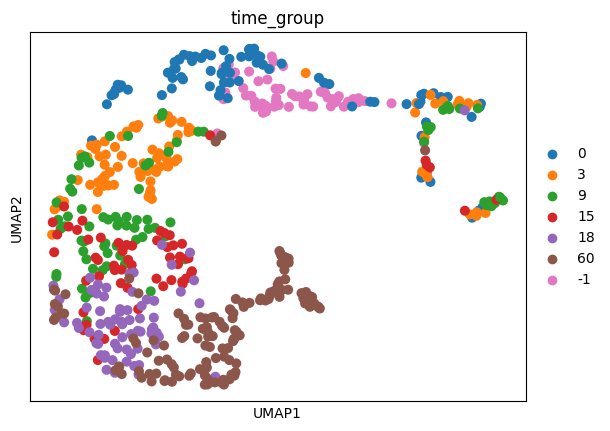

In [18]:
sc.pl.umap(adata1, color=["time_group"])

#### Original model architecture
It works while it may need to be better adapted to the loss function

In [19]:
import TemporalVAE as tvae
from nnlite import NNWrapper
from functools import partial

torch.manual_seed(0)
dev = 'cuda:2' if torch.cuda.is_available() else 'cpu'

# small bug when hidden_dims is given [256, 128, 64]
model = tvae.TVAE_Origin(3737, 32, hidden_dims=None)
criterion = partial(Loss_TVAE, beta=1.0, fix_x_var=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=0.95)

my_wrapper = NNWrapper(model, criterion, optimizer, device=dev, reconstruct=True)
my_wrapper.fit(train_loader, epoch=300, validation_loader=None, verbose=False)

100%|█████████████████████████████████████████| 300/300 [00:17<00:00, 17.29it/s]


/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


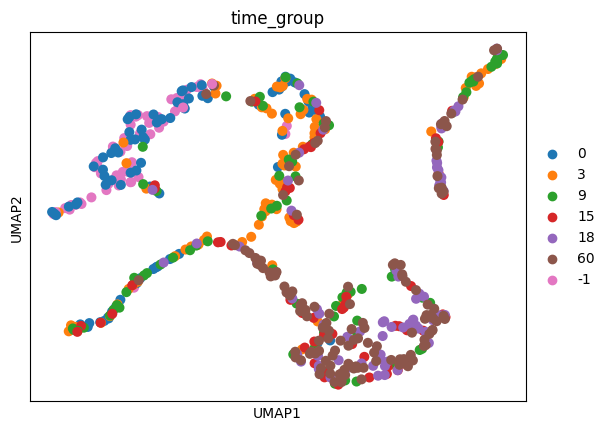

In [20]:
data_X = torch.Tensor(adata.X).to(torch.device(dev))
data_Z = model.encoder(data_X)

adata1 = adata.copy()
adata1.obsm['X_pca'] = data_Z.cpu().data.numpy()
adata1.obs["time_group"] = adata1.obs['time'].values.astype('str')

sc.pp.neighbors(adata1, n_neighbors=10, n_pcs=32)
sc.tl.umap(adata1)

sc.pl.umap(adata1, color=["time_group"])